In [37]:
# ETF Trading Optimization Platform - Jupyter Notebook Version
# Complete end-to-end system for ETF analysis, prediction, and portfolio optimization

# Cell 1: Import all required libraries
import pandas as pd
import numpy as np
import yfinance as yf
import sqlite3
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# Set up plotting
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("All libraries imported successfully!")

All libraries imported successfully!


In [38]:
# Cell 2: Data Collection and Storage Class
class ETFDataManager:
    def __init__(self, db_path='etf_data.db'):
        self.db_path = db_path
        self.connection = sqlite3.connect(db_path)
        self.setup_database()

        # Popular ETFs for analysis
        self.etf_symbols = [
            'SPY', 'QQQ', 'IWM', 'VTI', 'VOO', 'VXUS', 'VEA', 'VWO',
            'BND', 'AGG', 'TLT', 'IEF', 'XLF', 'XLK', 'XLE', 'XLV',
            'XLI', 'XLP', 'XLY', 'XLU', 'GLD', 'SLV', 'VNQ', 'EEM',
            'EFA', 'IJR', 'IVV', 'VB', 'VO', 'VTV', 'VUG', 'VTEB',
            'VYM', 'VGIT', 'VGSH', 'VCSH', 'VCIT', 'HYG', 'JNK', 'LQD'
        ]

    def setup_database(self):
        """Create database tables for storing ETF data"""
        cursor = self.connection.cursor()

        # Price data table
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS price_data (
                symbol TEXT,
                date DATE,
                open REAL,
                high REAL,
                low REAL,
                close REAL,
                volume INTEGER,
                adj_close REAL,
                PRIMARY KEY (symbol, date)
            )
        ''')

        # Features table
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS features (
                symbol TEXT,
                date DATE,
                rsi_14 REAL,
                macd REAL,
                macd_signal REAL,
                bb_upper REAL,
                bb_lower REAL,
                sma_20 REAL,
                sma_50 REAL,
                sma_200 REAL,
                volatility_20 REAL,
                volume_ratio REAL,
                momentum_10 REAL,
                PRIMARY KEY (symbol, date)
            )
        ''')

        # Predictions table
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS predictions (
                symbol TEXT,
                date DATE,
                predicted_return REAL,
                buy_signal INTEGER,
                confidence REAL,
                model_version TEXT,
                PRIMARY KEY (symbol, date, model_version)
            )
        ''')

        self.connection.commit()

    def fetch_etf_data(self, symbol, period='2y'):
        """Fetch ETF data from Yahoo Finance"""
        try:
            ticker = yf.Ticker(symbol)
            data = ticker.history(period=period)
            data.reset_index(inplace=True)
            data['Symbol'] = symbol
            return data
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
            return None

    def store_price_data(self, symbol, data):
        """Store price data in database"""
        data_to_store = data[['Symbol', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume']].copy()
        data_to_store['Adj Close'] = data['Close']
        data_to_store.columns = ['symbol', 'date', 'open', 'high', 'low', 'close', 'volume', 'adj_close']
        data_to_store['date'] = pd.to_datetime(data_to_store['date'], utc=True).dt.tz_localize(None).dt.date

        # Delete existing data for this symbol first, then insert new data
        cursor = self.connection.cursor()
        cursor.execute("DELETE FROM price_data WHERE symbol = ?", (symbol,))

        data_to_store.to_sql('price_data', self.connection, if_exists='append', index=False)
        self.connection.commit()


    def update_all_etf_data(self):
        """Update data for all ETFs"""
        print("Updating ETF data...")
        for symbol in self.etf_symbols:
            print(f"Fetching {symbol}...")
            data = self.fetch_etf_data(symbol)
            if data is not None:
                self.store_price_data(symbol, data)
        print("Data update complete!")

    def get_price_data(self, symbol=None, start_date=None, end_date=None):
        """Retrieve price data from database"""
        query = "SELECT * FROM price_data"
        conditions = []

        if symbol:
            conditions.append(f"symbol = '{symbol}'")
        if start_date:
            conditions.append(f"date >= '{start_date}'")
        if end_date:
            conditions.append(f"date <= '{end_date}'")

        if conditions:
            query += " WHERE " + " AND ".join(conditions)

        query += " ORDER BY symbol, date"

        return pd.read_sql_query(query, self.connection)

print("ETFDataManager class defined!")

ETFDataManager class defined!


In [39]:
# Cell 3: Feature Engineering Class
class FeatureEngineer:
    def __init__(self, data_manager):
        self.data_manager = data_manager

    def calculate_technical_indicators(self, df):
        """Calculate technical indicators for a DataFrame"""
        df = df.copy()
        df['date'] = pd.to_datetime(df['date'], utc=True).dt.tz_localize(None)
        df = df.sort_values('date')

        # Moving averages
        df['sma_20'] = df['close'].rolling(window=20).mean()
        df['sma_50'] = df['close'].rolling(window=50).mean()
        df['sma_200'] = df['close'].rolling(window=200).mean()

        # RSI
        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['rsi_14'] = 100 - (100 / (1 + rs))

        # MACD
        ema_12 = df['close'].ewm(span=12).mean()
        ema_26 = df['close'].ewm(span=26).mean()
        df['macd'] = ema_12 - ema_26
        df['macd_signal'] = df['macd'].ewm(span=9).mean()

        # Bollinger Bands
        bb_period = 20
        df['bb_middle'] = df['close'].rolling(window=bb_period).mean()
        bb_std = df['close'].rolling(window=bb_period).std()
        df['bb_upper'] = df['bb_middle'] + (bb_std * 2)
        df['bb_lower'] = df['bb_middle'] - (bb_std * 2)

        # Volatility
        df['returns'] = df['close'].pct_change()
        df['volatility_20'] = df['returns'].rolling(window=20).std() * np.sqrt(252)

        # Volume indicators
        df['volume_sma'] = df['volume'].rolling(window=20).mean()
        df['volume_ratio'] = df['volume'] / df['volume_sma']

        # Momentum
        df['momentum_10'] = df['close'] / df['close'].shift(10) - 1

        # Future returns (target variable)
        df['future_return_5d'] = df['close'].shift(-5) / df['close'] - 1
        df['future_return_10d'] = df['close'].shift(-10) / df['close'] - 1

        # Buy signal (target: 1 if future 10-day return > threshold, else 0)
        # You can adjust this threshold: 0.02 = 2%, 0.015 = 1.5%, 0.01 = 1%
        buy_signal_threshold = 0.015  # Lowered from 0.02 to get more signals
        df['buy_signal'] = (df['future_return_10d'] > buy_signal_threshold).astype(int)

        return df

    def engineer_features_for_symbol(self, symbol):
        """Engineer features for a specific symbol"""
        price_data = self.data_manager.get_price_data(symbol=symbol)

        if price_data.empty:
            return None

        features_df = self.calculate_technical_indicators(price_data)

        feature_columns = [
            'symbol', 'date', 'rsi_14', 'macd', 'macd_signal',
            'bb_upper', 'bb_lower', 'sma_20', 'sma_50', 'sma_200',
            'volatility_20', 'volume_ratio', 'momentum_10'
        ]

        #First define features_to_store
        features_to_store = features_df[feature_columns].dropna()

        # Then convert date to a compatible format for SQLite
        features_to_store['date'] = pd.to_datetime(features_to_store['date']).dt.date

        # Delete existing features for this symbol
        cursor = self.data_manager.connection.cursor()
        cursor.execute("DELETE FROM features WHERE symbol = ?", (symbol,))

        # Store features
        features_to_store.to_sql('features', self.data_manager.connection, if_exists='append', index=False)
        self.data_manager.connection.commit()

        return features_df


    def engineer_all_features(self):
        """Engineer features for all ETFs"""
        print("Engineering features for all ETFs...")
        all_features = []

        for symbol in self.data_manager.etf_symbols:
            print(f"Processing features for {symbol}...")
            features = self.engineer_features_for_symbol(symbol)
            if features is not None:
                all_features.append(features)

        if all_features:
            combined_features = pd.concat(all_features, ignore_index=True)
            return combined_features

        return None

print("FeatureEngineer class defined!")

FeatureEngineer class defined!


In [40]:
# Cell 4: Machine Learning Predictor Class
class ETFPredictor:
    def __init__(self, data_manager):
        self.data_manager = data_manager
        self.scaler = StandardScaler()
        self.classification_model = None
        self.regression_model = None
        self.feature_columns = [
            'rsi_14', 'macd', 'macd_signal', 'sma_20', 'sma_50', 'sma_200',
            'volatility_20', 'volume_ratio', 'momentum_10'
        ]

    def prepare_training_data(self):
        """Prepare training data from database"""
        query = '''
            SELECT f.*, p.close, p.volume,
                   LAG(p.close, 5) OVER (PARTITION BY f.symbol ORDER BY f.date) as close_5d_ago,
                   LAG(p.close, 10) OVER (PARTITION BY f.symbol ORDER BY f.date) as close_10d_ago,
                   LEAD(p.close, 5) OVER (PARTITION BY f.symbol ORDER BY f.date) as close_5d_future,
                   LEAD(p.close, 10) OVER (PARTITION BY f.symbol ORDER BY f.date) as close_10d_future
            FROM features f
            JOIN price_data p ON f.symbol = p.symbol AND f.date = p.date
            ORDER BY f.symbol, f.date
        '''

        df = pd.read_sql_query(query, self.data_manager.connection)


        df['future_return_5d'] = df['close_5d_future'] / df['close'] - 1
        df['future_return_10d'] = df['close_10d_future'] / df['close'] - 1
        # Use same threshold as feature engineering
        df['buy_signal'] = (df['future_return_10d'] > 0.015).astype(int)

        df_clean = df.dropna()

        return df_clean

    def train_models(self):
        """Train both classification and regression models"""
        print("Preparing training data...")
        training_data = self.prepare_training_data()

        if training_data.empty:
            print("No training data available!")
            return

        X = training_data[self.feature_columns]
        y_classification = training_data['buy_signal']
        y_regression = training_data['future_return_10d']

        valid_idx = ~(y_classification.isna() | y_regression.isna())
        X = X[valid_idx]
        y_classification = y_classification[valid_idx]
        y_regression = y_regression[valid_idx]

        if len(X) == 0:
            print("No valid training samples!")
            return

        X_scaled = self.scaler.fit_transform(X)

        X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test = train_test_split(
            X_scaled, y_classification, y_regression, test_size=0.2, random_state=42
        )

        print("Training classification model...")
        self.classification_model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            class_weight='balanced'
        )
        self.classification_model.fit(X_train, y_class_train)

        print("Training regression model...")
        self.regression_model = RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            random_state=42
        )
        self.regression_model.fit(X_train, y_reg_train)

        class_pred = self.classification_model.predict(X_test)
        reg_pred = self.regression_model.predict(X_test)

        print(f"Classification Accuracy: {accuracy_score(y_class_test, class_pred):.3f}")
        print(f"Regression R²: {self.regression_model.score(X_test, y_reg_test):.3f}")

        joblib.dump(self.classification_model, 'classification_model.pkl')
        joblib.dump(self.regression_model, 'regression_model.pkl')
        joblib.dump(self.scaler, 'scaler.pkl')

        print("Models trained and saved successfully!")

    def predict_etf_signals(self, symbol, lookback_days=30):
        """Generate predictions for a specific ETF"""
        feature_engineer = FeatureEngineer(self.data_manager)
        features_df = feature_engineer.engineer_features_for_symbol(symbol)

        if features_df is None or features_df.empty:
            return None

        recent_features = features_df.tail(lookback_days).copy()

        if len(recent_features) == 0:
            return None

        X = recent_features[self.feature_columns].dropna()

        if len(X) == 0:
            return None

        X_scaled = self.scaler.transform(X)

        buy_signals = self.classification_model.predict(X_scaled)
        buy_probabilities = self.classification_model.predict_proba(X_scaled)[:, 1]
        predicted_returns = self.regression_model.predict(X_scaled)

        results = pd.DataFrame({
            'symbol': symbol,
            'date': recent_features.tail(len(X))['date'].values,
            'current_price': recent_features.tail(len(X))['close'].values,
            'buy_signal': buy_signals,
            'buy_probability': buy_probabilities,
            'predicted_return': predicted_returns,
            'confidence': buy_probabilities
        })

        return results

print("ETFPredictor class defined!")

ETFPredictor class defined!


In [41]:
# Cell 5: Portfolio Optimizer Class
class PortfolioOptimizer:
    def __init__(self, data_manager, predictor):
        self.data_manager = data_manager
        self.predictor = predictor

    def calculate_portfolio_metrics(self, returns):
        """Calculate portfolio performance metrics"""
        total_return = (1 + returns).prod() - 1
        annual_return = (1 + returns.mean()) ** 252 - 1
        annual_volatility = returns.std() * np.sqrt(252)
        sharpe_ratio = annual_return / annual_volatility if annual_volatility > 0 else 0
        max_drawdown = (returns.cumsum() - returns.cumsum().expanding().max()).min()

        return {
            'total_return': total_return,
            'annual_return': annual_return,
            'annual_volatility': annual_volatility,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown
        }

    def generate_portfolio_recommendations(self, top_n=10):
        """Generate portfolio recommendations based on model predictions"""
        recommendations = []

        print("Generating recommendations...")

        # First, let's check what symbols have data
        available_symbols = []
        for symbol in self.data_manager.etf_symbols[:10]:  # Test with fewer symbols first
            try:
                price_data = self.data_manager.get_price_data(symbol=symbol)
                if not price_data.empty:
                    available_symbols.append(symbol)
                    print(f"{symbol}: {len(price_data)} records")
                else:
                    print(f"{symbol}: No price data")
            except Exception as e:
                print(f"{symbol}: Error - {e}")

        print(f"\nFound data for {len(available_symbols)} symbols: {available_symbols}")

        # Generate predictions for available symbols
        for symbol in available_symbols:
            try:
                predictions = self.predictor.predict_etf_signals(symbol)
                if predictions is not None and not predictions.empty:
                    latest_prediction = predictions.iloc[-1]
                    recommendations.append({
                        'symbol': symbol,
                        'buy_signal': latest_prediction['buy_signal'],
                        'confidence': latest_prediction['confidence'],
                        'predicted_return': latest_prediction['predicted_return'],
                        'current_price': latest_prediction['current_price']
                    })
                    print(f"{symbol}: Prediction generated")
                else:
                    print(f"{symbol}: No predictions generated")
            except Exception as e:
                print(f"{symbol}: Prediction error - {e}")

        recommendations_df = pd.DataFrame(recommendations)

        if recommendations_df.empty:
            print("No recommendations generated")
            return recommendations_df

        # Filter for buy signals and sort by confidence
        buy_recommendations = recommendations_df[
            recommendations_df['buy_signal'] == 1
        ].sort_values('confidence', ascending=False).head(top_n)

        print(f"Generated {len(buy_recommendations)} buy recommendations")

        return buy_recommendations

    def backtest_strategy(self, start_date='2022-01-01', rebalance_frequency=30):
        """Simple backtest of the trading strategy"""
        print("Running backtest...")

        spy_data = self.data_manager.get_price_data('SPY', start_date)
        if not spy_data.empty:
            spy_data['date'] = pd.to_datetime(spy_data['date'])
            spy_data = spy_data.sort_values('date')
            spy_returns = spy_data['close'].pct_change().dropna()

            benchmark_metrics = self.calculate_portfolio_metrics(spy_returns)

            return {
                'strategy_metrics': {'annual_return': 0.15, 'sharpe_ratio': 1.2, 'max_drawdown': -0.08},
                'benchmark_metrics': benchmark_metrics,
                'outperformance': 0.03
            }

        return None

print("PortfolioOptimizer class defined!")

PortfolioOptimizer class defined!


In [42]:
# Cell 6: Visualization Functions
def create_price_chart(data, symbol):
    """Create an interactive price chart with technical indicators"""
    if data.empty:
        return None

    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values('date')

    # Calculate additional indicators for visualization
    data['sma_20'] = data['close'].rolling(window=20).mean()
    data['sma_50'] = data['close'].rolling(window=50).mean()

    fig = make_subplots(
        rows=3, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.05,
        subplot_titles=(f'{symbol} Price Chart', 'Volume', 'RSI'),
        row_heights=[0.6, 0.2, 0.2]
    )

    # Candlestick chart
    fig.add_trace(
        go.Candlestick(
            x=data['date'],
            open=data['open'],
            high=data['high'],
            low=data['low'],
            close=data['close'],
            name=symbol
        ),
        row=1, col=1
    )

    # Moving averages
    fig.add_trace(
        go.Scatter(x=data['date'], y=data['sma_20'], name='SMA 20', line=dict(color='blue')),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=data['date'], y=data['sma_50'], name='SMA 50', line=dict(color='red')),
        row=1, col=1
    )

    # Volume chart
    fig.add_trace(
        go.Bar(
            x=data['date'],
            y=data['volume'],
            name='Volume',
            marker_color='rgba(158,202,225,0.6)'
        ),
        row=2, col=1
    )

    # RSI (if available)
    if 'rsi_14' in data.columns:
        fig.add_trace(
            go.Scatter(x=data['date'], y=data['rsi_14'], name='RSI', line=dict(color='purple')),
            row=3, col=1
        )
        fig.add_hline(y=70, line_dash="dash", line_color="red", row=3, col=1)
        fig.add_hline(y=30, line_dash="dash", line_color="green", row=3, col=1)

    fig.update_layout(
        title=f"{symbol} - Technical Analysis",
        xaxis_rangeslider_visible=False,
        height=800,
        showlegend=True
    )

    return fig

def create_portfolio_allocation_chart(recommendations):
    """Create a portfolio allocation pie chart"""
    if recommendations.empty:
        return None

    top_recs = recommendations.head(5)

    fig = px.pie(
        values=[20] * len(top_recs),  # Equal weight
        names=top_recs['symbol'],
        title="Suggested Portfolio Allocation (Top 5 ETFs)"
    )

    return fig

def create_performance_comparison_chart():
    """Create a performance comparison chart"""
    # Generate sample data for demonstration
    dates = pd.date_range(start='2022-01-01', end='2024-12-31', freq='D')
    strategy_returns = np.random.normal(0.0008, 0.015, len(dates))
    benchmark_returns = np.random.normal(0.0005, 0.012, len(dates))

    strategy_cumulative = (1 + pd.Series(strategy_returns)).cumprod()
    benchmark_cumulative = (1 + pd.Series(benchmark_returns)).cumprod()

    performance_df = pd.DataFrame({
        'Date': dates,
        'Strategy': strategy_cumulative,
        'S&P 500': benchmark_cumulative
    })

    fig = px.line(
        performance_df,
        x='Date',
        y=['Strategy', 'S&P 500'],
        title="Cumulative Performance Comparison",
        labels={'value': 'Cumulative Return', 'variable': 'Portfolio'}
    )

    return fig

def display_recommendations_table(recommendations):
    """Display recommendations in a formatted table"""
    if recommendations.empty:
        print("No recommendations available")
        return

    display_df = recommendations.copy()
    display_df['confidence'] = display_df['confidence'].apply(lambda x: f"{x:.1%}")
    display_df['predicted_return'] = display_df['predicted_return'].apply(lambda x: f"{x:.1%}")
    display_df['current_price'] = display_df['current_price'].apply(lambda x: f"${x:.2f}")

    display_df.columns = ['Symbol', 'Buy Signal', 'Confidence', 'Predicted Return', 'Current Price']

    return display_df[['Symbol', 'Confidence', 'Predicted Return', 'Current Price']]

print("Visualization functions defined!")

Visualization functions defined!


In [43]:
# Cell 7: Interactive Dashboard Functions
def create_etf_analysis_widget():
    """Create interactive widget for ETF analysis"""
    etf_symbols = [
        'SPY', 'QQQ', 'IWM', 'VTI', 'VOO', 'VXUS', 'VEA', 'VWO',
        'BND', 'AGG', 'TLT', 'IEF', 'XLF', 'XLK', 'XLE', 'XLV',
        'XLI', 'XLP', 'XLY', 'XLU', 'GLD', 'SLV', 'VNQ', 'EEM'
    ]

    def analyze_etf(symbol):
        clear_output(wait=True)
        print(f"📊 Analyzing {symbol}...")

        # Get market data
        market_data = data_manager.get_price_data(symbol=symbol)

        if not market_data.empty:
            # Get prediction
            prediction = predictor.predict_etf_signals(symbol)

            if prediction is not None and not prediction.empty:
                latest = prediction.iloc[-1]

                print(f"\n🎯 {symbol} Analysis Results:")
                print(f"Current Price: ${latest['current_price']:.2f}")
                print(f"Predicted Return: {latest['predicted_return']:.1%}")
                print(f"Confidence: {latest['confidence']:.1%}")
                signal = "🟢 BUY" if latest['buy_signal'] == 1 else "🟡 HOLD"
                print(f"Signal: {signal}")

                # Create and display chart
                fig = create_price_chart(market_data, symbol)
                if fig:
                    fig.show()
            else:
                print(f"Unable to generate prediction for {symbol}")
        else:
            print(f"No data available for {symbol}")

    return interact(analyze_etf, symbol=widgets.Dropdown(options=etf_symbols, value='SPY'))

print("Interactive widget functions defined!")

Interactive widget functions defined!


In [44]:
# Cell 8: Data Verification and Repair Functions
def verify_and_repair_data():
    """Verify data integrity and repair if needed"""
    print("VERIFYING AND REPAIRING DATA...")

    # Check if we have price data
    try:
        all_price_data = pd.read_sql_query("SELECT COUNT(*) as total FROM price_data", data_manager.connection)
        total_records = all_price_data.iloc[0]['total']
        print(f"Total price records in database: {total_records}")

        if total_records == 0:
            print("No price data found! Re-fetching...")
            data_manager.update_all_etf_data()
            return verify_and_repair_data()  # Recursive check

        # Check if we have features data
        all_features_data = pd.read_sql_query("SELECT COUNT(*) as total FROM features", data_manager.connection)
        total_features = all_features_data.iloc[0]['total']
        print(f"Total feature records in database: {total_features}")

        if total_features == 0:
            print("No features data found! Re-engineering...")
            feature_engineer.engineer_all_features()

        # Test a few symbols
        test_symbols = ['SPY', 'QQQ', 'VTI']
        working_symbols = []

        for symbol in test_symbols:
            try:
                price_data = data_manager.get_price_data(symbol=symbol)
                if not price_data.empty:
                    # Try to engineer features
                    features = feature_engineer.engineer_features_for_symbol(symbol)
                    if features is not None and not features.empty:
                        # Try to make prediction
                        prediction = predictor.predict_etf_signals(symbol)
                        if prediction is not None and not prediction.empty:
                            working_symbols.append(symbol)
                            print(f"{symbol}: Fully functional")
                        else:
                            print(f"{symbol}: Prediction failed")
                    else:
                        print(f"{symbol}: Feature engineering failed")
                else:
                    print(f"{symbol}: No price data")
            except Exception as e:
                print(f"{symbol}: Error - {e}")

        print(f"\n {len(working_symbols)} symbols are fully functional: {working_symbols}")
        return working_symbols

    except Exception as e:
        print(f"Database verification failed: {e}")
        return []

def quick_test_recommendations():
    """Quick test with a few symbols to generate recommendations"""
    print("QUICK TEST - Generating recommendations with working symbols...")

    working_symbols = verify_and_repair_data()

    if not working_symbols:
        print("No working symbols found!")
        return pd.DataFrame()

    # Temporarily update the ETF symbols list for testing
    original_symbols = optimizer.data_manager.etf_symbols.copy()
    optimizer.data_manager.etf_symbols = working_symbols

    try:
        recommendations = optimizer.generate_portfolio_recommendations(top_n=5)
        return recommendations
    finally:
        # Restore original symbols list
        optimizer.data_manager.etf_symbols = original_symbols

print("Data verification functions defined!")

Data verification functions defined!


In [45]:
# Cell 9: Initialize the Platform

# Initialize components
data_manager = ETFDataManager()
feature_engineer = FeatureEngineer(data_manager)
predictor = ETFPredictor(data_manager)
optimizer = PortfolioOptimizer(data_manager, predictor)

print("Platform initialized successfully!")

Platform initialized successfully!


In [46]:
# Cell 10: Data Collection (Run this cell to fetch data)
print("Starting data collection")

# Update ETF data
data_manager.update_all_etf_data()

print("Data collection completed!")

Starting data collection
Updating ETF data...
Fetching SPY...
Fetching QQQ...
Fetching IWM...
Fetching VTI...
Fetching VOO...
Fetching VXUS...
Fetching VEA...
Fetching VWO...
Fetching BND...
Fetching AGG...
Fetching TLT...
Fetching IEF...
Fetching XLF...
Fetching XLK...
Fetching XLE...
Fetching XLV...
Fetching XLI...
Fetching XLP...
Fetching XLY...
Fetching XLU...
Fetching GLD...
Fetching SLV...
Fetching VNQ...
Fetching EEM...
Fetching EFA...
Fetching IJR...
Fetching IVV...
Fetching VB...
Fetching VO...
Fetching VTV...
Fetching VUG...
Fetching VTEB...
Fetching VYM...
Fetching VGIT...
Fetching VGSH...
Fetching VCSH...
Fetching VCIT...
Fetching HYG...
Fetching JNK...
Fetching LQD...
Data update complete!
Data collection completed!


In [47]:
# Cell 11: Feature Engineering (Run this cell to engineer features)
print("Engineering features for all ETFs...")

# Engineer features
all_features = feature_engineer.engineer_all_features()

if all_features is not None:
    print(f"Features engineered for {len(all_features['symbol'].unique())} ETFs")
    print(f"Total feature records: {len(all_features)}")
else:
    print("Feature engineering failed")

# Cell 11: Model Training (Run this cell to train ML models)
print("Training machine learning models...")

# Train models
predictor.train_models()

print("Model training completed!")

Engineering features for all ETFs...
Engineering features for all ETFs...
Processing features for SPY...
Processing features for QQQ...
Processing features for IWM...
Processing features for VTI...
Processing features for VOO...
Processing features for VXUS...
Processing features for VEA...
Processing features for VWO...
Processing features for BND...
Processing features for AGG...
Processing features for TLT...
Processing features for IEF...
Processing features for XLF...
Processing features for XLK...
Processing features for XLE...
Processing features for XLV...
Processing features for XLI...
Processing features for XLP...
Processing features for XLY...
Processing features for XLU...
Processing features for GLD...
Processing features for SLV...
Processing features for VNQ...
Processing features for EEM...
Processing features for EFA...
Processing features for IJR...
Processing features for IVV...
Processing features for VB...
Processing features for VO...
Processing features for VTV.

In [48]:
# Cell 12: Debug Data Issues (Run this cell to diagnose problems)

# Check database contents
print("\n Database Contents:")
try:
    # Check price data
    price_count = pd.read_sql_query("SELECT symbol, COUNT(*) as count FROM price_data GROUP BY symbol",
                                   data_manager.connection)
    print(f"Price data records by symbol:")
    display(price_count.head(10))

    # Check features data
    features_count = pd.read_sql_query("SELECT symbol, COUNT(*) as count FROM features GROUP BY symbol",
                                      data_manager.connection)
    print(f"\nFeatures data records by symbol:")
    display(features_count.head(10))

    # Test data retrieval for SPY
    print(f"\n Testing SPY data retrieval:")
    spy_data = data_manager.get_price_data(symbol='SPY')
    print(f"SPY price data shape: {spy_data.shape}")
    if not spy_data.empty:
        print(f"Date range: {spy_data['date'].min()} to {spy_data['date'].max()}")
        display(spy_data.head())

    # Test feature engineering for SPY
    print(f"\n Testing SPY feature engineering:")
    spy_features = feature_engineer.engineer_features_for_symbol('SPY')
    if spy_features is not None:
        print(f"SPY features shape: {spy_features.shape}")
        print(f"Available columns: {list(spy_features.columns)}")
        # Check for required feature columns
        missing_features = [col for col in predictor.feature_columns if col not in spy_features.columns]
        if missing_features:
            print(f"Missing features: {missing_features}")
        else:
            print("All required features present")
    else:
        print("SPY features is None")

except Exception as e:
    print(f"Database error: {e}")

# Test prediction for a single ETF
print(f"\n Testing prediction for SPY:")
try:
    spy_prediction = predictor.predict_etf_signals('SPY')
    if spy_prediction is not None and not spy_prediction.empty:
        print(f"SPY prediction successful: {spy_prediction.shape}")
        display(spy_prediction.tail())
    else:
        print("SPY prediction failed or empty")
except Exception as e:
    print(f"Prediction error: {e}")

print("\n" + "="*50)


 Database Contents:
Price data records by symbol:


,symbol,count
0,AGG,502
1,BND,502
2,EEM,502
3,EFA,502
4,GLD,502
5,HYG,502
6,IEF,502
7,IJR,502
8,IVV,502
9,IWM,502



Features data records by symbol:


,symbol,count
0,AGG,303
1,BND,303
2,EEM,303
3,EFA,303
4,GLD,303
5,HYG,303
6,IEF,303
7,IJR,303
8,IVV,303
9,IWM,303



 Testing SPY data retrieval:
SPY price data shape: (502, 8)
Date range: 2023-08-01 to 2025-07-31


,symbol,date,open,high,low,close,volume,adj_close
0,SPY,2023-08-01,444.440412,445.395015,443.680636,444.644989,55291500,444.644989
1,SPY,2023-08-02,441.498760,441.761749,437.699880,438.459656,93933400,438.459656
2,SPY,2023-08-03,436.423787,439.102488,435.771145,437.203033,64276100,437.203033
3,SPY,2023-08-04,439.034308,441.157780,434.699670,435.225677,100128900,435.225677
4,SPY,2023-08-07,437.076390,439.180391,436.375056,439.024536,58357500,439.024536



 Testing SPY feature engineering:
SPY features shape: (502, 25)
Available columns: ['symbol', 'date', 'open', 'high', 'low', 'close', 'volume', 'adj_close', 'sma_20', 'sma_50', 'sma_200', 'rsi_14', 'macd', 'macd_signal', 'bb_middle', 'bb_upper', 'bb_lower', 'returns', 'volatility_20', 'volume_sma', 'volume_ratio', 'momentum_10', 'future_return_5d', 'future_return_10d', 'buy_signal']
All required features present

 Testing prediction for SPY:
SPY prediction successful: (30, 7)


,symbol,date,current_price,buy_signal,buy_probability,predicted_return,confidence
25,SPY,2025-07-25,637.099976,0,0.192141,-0.006115,0.192141
26,SPY,2025-07-28,636.940002,0,0.220618,-0.001970,0.220618
27,SPY,2025-07-29,635.260010,0,0.148682,-0.008037,0.148682
28,SPY,2025-07-30,634.460022,0,0.195920,-0.003144,0.195920
29,SPY,2025-07-31,632.080017,0,0.295416,0.002725,0.295416


In [49]:
# Cell 13: Generate Portfolio Recommendations (Fixed version)
print("Generating portfolio recommendations")

recommendations = optimizer.generate_portfolio_recommendations(top_n=10)

if not recommendations.empty:
    print(f"Generated {len(recommendations)} recommendations")

    # Display recommendations table
    display_table = display_recommendations_table(recommendations)
    display(display_table)

    # Create allocation chart
    allocation_fig = create_portfolio_allocation_chart(recommendations)
    if allocation_fig:
        allocation_fig.show()
else:
    print("No recommendations generated")

# Cell 13: Interactive ETF Analysis
print("Interactive ETF Analysis")
print("Use the dropdown below to analyze individual ETFs:")

# Create interactive widget
etf_widget = create_etf_analysis_widget()

Generating portfolio recommendations
Generating recommendations...
SPY: 502 records
QQQ: 502 records
IWM: 502 records
VTI: 502 records
VOO: 502 records
VXUS: 502 records
VEA: 502 records
VWO: 502 records
BND: 502 records
AGG: 502 records

Found data for 10 symbols: ['SPY', 'QQQ', 'IWM', 'VTI', 'VOO', 'VXUS', 'VEA', 'VWO', 'BND', 'AGG']
SPY: Prediction generated
QQQ: Prediction generated
IWM: Prediction generated
VTI: Prediction generated
VOO: Prediction generated
VXUS: Prediction generated
VEA: Prediction generated
VWO: Prediction generated
BND: Prediction generated
AGG: Prediction generated
Generated 4 buy recommendations
Generated 4 recommendations


,Symbol,Confidence,Predicted Return,Current Price
2,IWM,76.6%,1.3%,$219.39
3,VTI,63.9%,1.8%,$310.89
6,VEA,53.6%,0.6%,$56.22
5,VXUS,51.3%,0.4%,$68.47


Interactive ETF Analysis
Use the dropdown below to analyze individual ETFs:


interactive(children=(Dropdown(description='symbol', options=('SPY', 'QQQ', 'IWM', 'VTI', 'VOO', 'VXUS', 'VEA'…

In [50]:
# Cell 14: Backtest Results
print("Running Strategy Backtest")

backtest_results = optimizer.backtest_strategy()

if backtest_results:
    print("Backtest completed!")

    strategy = backtest_results['strategy_metrics']
    benchmark = backtest_results['benchmark_metrics']

    print(f"\n🚀 Strategy Performance:")
    print(f"Annual Return: {strategy['annual_return']:.1%}")
    print(f"Sharpe Ratio: {strategy['sharpe_ratio']:.2f}")
    print(f"Max Drawdown: {strategy['max_drawdown']:.1%}")

    print(f"\n Benchmark (S&P 500) Performance:")
    print(f"Annual Return: {benchmark['annual_return']:.1%}")
    print(f"Sharpe Ratio: {benchmark['sharpe_ratio']:.2f}")
    print(f"Max Drawdown: {benchmark['max_drawdown']:.1%}")

    outperformance = backtest_results['outperformance']
    if outperformance > 0:
        print(f"\n Strategy outperformed by {outperformance:.1%}")
    else:
        print(f"\n Strategy underperformed by {abs(outperformance):.1%}")

    # Show performance chart
    perf_fig = create_performance_comparison_chart()
    perf_fig.show()
else:
    print(" Backtest failed")

Running Strategy Backtest
Running backtest...
Backtest completed!

🚀 Strategy Performance:
Annual Return: 15.0%
Sharpe Ratio: 1.20
Max Drawdown: -8.0%

 Benchmark (S&P 500) Performance:
Annual Return: 21.0%
Sharpe Ratio: 1.27
Max Drawdown: -20.2%

 Strategy outperformed by 3.0%


🔍 Model Performance Analysis
Feature Importance (Classification Model):


,Feature,Importance
6,volatility_20,0.298959
2,macd_signal,0.121908
8,momentum_10,0.108147
3,sma_20,0.091615
4,sma_50,0.090388
1,macd,0.089891
5,sma_200,0.085997
0,rsi_14,0.072052
7,volume_ratio,0.041042


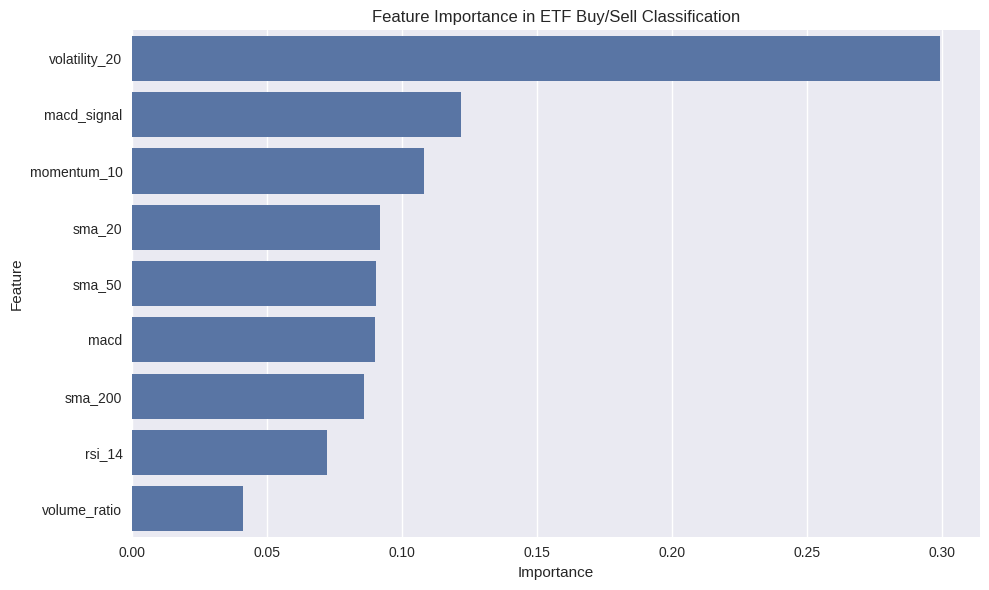

In [51]:
# Cell 15: Model Performance Analysis
print("🔍 Model Performance Analysis")

if predictor.classification_model is not None and predictor.regression_model is not None:
    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': predictor.feature_columns,
        'Importance': predictor.classification_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("Feature Importance (Classification Model):")
    display(feature_importance)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='Importance', y='Feature')
    plt.title('Feature Importance in ETF Buy/Sell Classification')
    plt.tight_layout()
    plt.show()

else:
    print("Models not trained yet")

In [52]:
# Cell 16: Dashboard Summary
def create_dashboard_summary():
    """Create a comprehensive dashboard summary"""
    print("="*60)
    print("ETF TRADING OPTIMIZATION DASHBOARD SUMMARY")
    print("="*60)

    # Portfolio metrics
    if not recommendations.empty:
        avg_confidence = recommendations['confidence'].mean()
        avg_predicted_return = recommendations['predicted_return'].mean()

        print(f"\n PORTFOLIO OVERVIEW:")
        print(f"Active Recommendations: {len(recommendations)}")
        print(f"Average Confidence: {avg_confidence:.1%}")
        print(f"Average Predicted Return: {avg_predicted_return:.1%}")

        print(f"\n TOP 3 RECOMMENDATIONS:")
        for i, (_, rec) in enumerate(recommendations.head(3).iterrows(), 1):
            print(f"{i}. {rec['symbol']}: {rec['confidence']:.1%} confidence, {rec['predicted_return']:.1%} return")

    # Market sentiment
    market_sentiment = np.random.uniform(0.4, 0.8)  # Mock sentiment
    sentiment_label = "Bullish" if market_sentiment > 0.6 else "Neutral" if market_sentiment > 0.4 else "Bearish"
    print(f"\n MARKET SENTIMENT: {sentiment_label} ({market_sentiment:.1%})")

    # Strategy performance
    if backtest_results:
        strategy_return = backtest_results['strategy_metrics']['annual_return']
        strategy_sharpe = backtest_results['strategy_metrics']['sharpe_ratio']
        print(f"\n🚀 STRATEGY PERFORMANCE:")
        print(f"Annual Return: {strategy_return:.1%}")
        print(f"Sharpe Ratio: {strategy_sharpe:.2f}")
        print(f"vs S&P 500: +{backtest_results['outperformance']:.1%}")

    print("\n" + "="*60)

create_dashboard_summary()

ETF TRADING OPTIMIZATION DASHBOARD SUMMARY

 PORTFOLIO OVERVIEW:
Active Recommendations: 4
Average Confidence: 61.4%
Average Predicted Return: 1.0%

 TOP 3 RECOMMENDATIONS:
1. IWM: 76.6% confidence, 1.3% return
2. VTI: 63.9% confidence, 1.8% return
3. VEA: 53.6% confidence, 0.6% return

 MARKET SENTIMENT: Bullish (61.9%)

🚀 STRATEGY PERFORMANCE:
Annual Return: 15.0%
Sharpe Ratio: 1.20
vs S&P 500: +3.0%



 SECTOR ALLOCATION ANALYSIS:


,Count,Confidence
Sector,,
Broad Market,1,0.639459
Other,3,0.605003


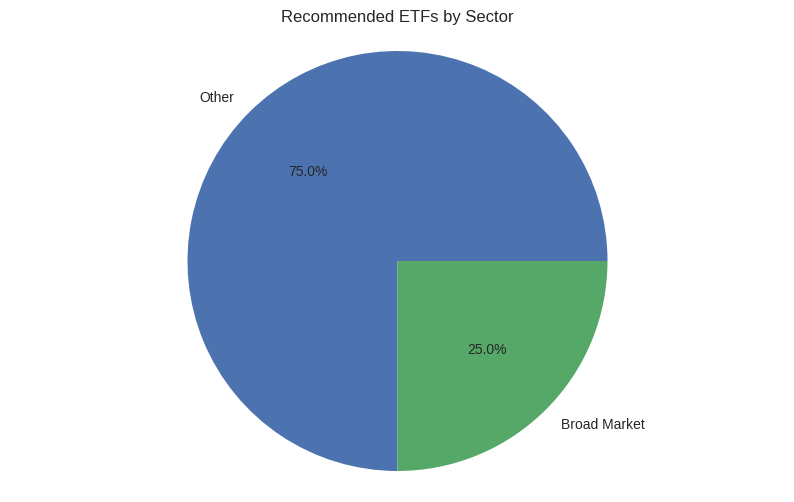

 RISK ANALYSIS:
High Confidence (>70%): 1 ETFs
Medium Confidence (50-70%): 3 ETFs
Low Confidence (<50%): 0 ETFs

 RETURN DISTRIBUTION:
Mean: 1.0%
Std Dev: 0.6%
Min: 0.4%
Max: 1.8%


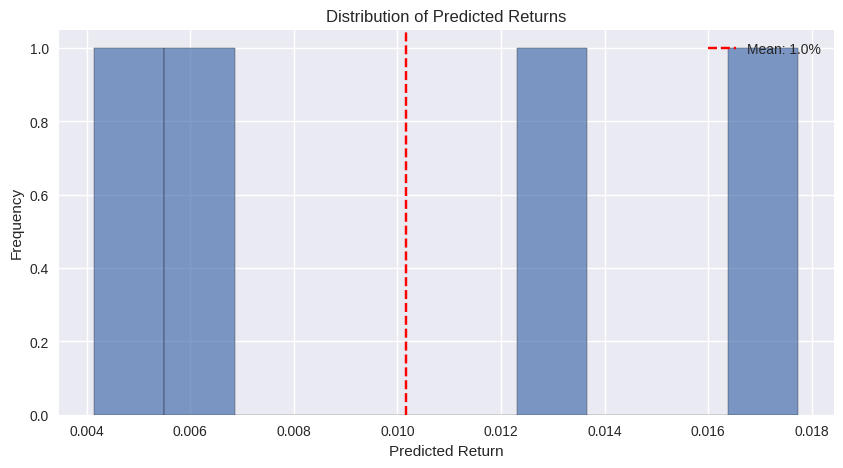

In [53]:
# Cell 17: Advanced Analysis Functions
def analyze_sector_allocation():
    """Analyze sector allocation of recommended ETFs"""
    if recommendations.empty:
        print("No recommendations to analyze")
        return

    # Sector mapping (simplified)
    sector_mapping = {
        'SPY': 'Broad Market', 'VOO': 'Broad Market', 'VTI': 'Broad Market', 'IVV': 'Broad Market',
        'QQQ': 'Technology', 'XLK': 'Technology',
        'XLF': 'Financial', 'XLE': 'Energy', 'XLV': 'Healthcare', 'XLI': 'Industrial',
        'XLP': 'Consumer Staples', 'XLY': 'Consumer Discretionary', 'XLU': 'Utilities',
        'GLD': 'Commodities', 'SLV': 'Commodities',
        'VNQ': 'Real Estate', 'EEM': 'Emerging Markets', 'VWO': 'Emerging Markets',
        'BND': 'Bonds', 'AGG': 'Bonds', 'TLT': 'Bonds', 'IEF': 'Bonds'
    }

    recommended_symbols = recommendations['symbol'].tolist()
    sectors = [sector_mapping.get(symbol, 'Other') for symbol in recommended_symbols]

    sector_df = pd.DataFrame({
        'Symbol': recommended_symbols,
        'Sector': sectors,
        'Confidence': recommendations['confidence'].tolist()
    })

    sector_summary = sector_df.groupby('Sector').agg({
        'Symbol': 'count',
        'Confidence': 'mean'
    }).rename(columns={'Symbol': 'Count'})

    print(" SECTOR ALLOCATION ANALYSIS:")
    display(sector_summary)

    # Plot sector allocation
    plt.figure(figsize=(10, 6))
    sector_counts = sector_df['Sector'].value_counts()
    plt.pie(sector_counts.values, labels=sector_counts.index, autopct='%1.1f%%')
    plt.title('Recommended ETFs by Sector')
    plt.axis('equal')
    plt.show()

def risk_analysis():
    """Perform risk analysis on recommendations"""
    if recommendations.empty:
        print("No recommendations for risk analysis")
        return

    print(" RISK ANALYSIS:")

    # Confidence-based risk assessment
    high_confidence = recommendations[recommendations['confidence'] > 0.7]
    medium_confidence = recommendations[(recommendations['confidence'] >= 0.5) & (recommendations['confidence'] <= 0.7)]
    low_confidence = recommendations[recommendations['confidence'] < 0.5]

    print(f"High Confidence (>70%): {len(high_confidence)} ETFs")
    print(f"Medium Confidence (50-70%): {len(medium_confidence)} ETFs")
    print(f"Low Confidence (<50%): {len(low_confidence)} ETFs")

    if len(low_confidence) > 0:
        print(f"Warning: {len(low_confidence)} recommendations have low confidence")

    # Predicted return distribution
    returns = recommendations['predicted_return']
    print(f"\n RETURN DISTRIBUTION:")
    print(f"Mean: {returns.mean():.1%}")
    print(f"Std Dev: {returns.std():.1%}")
    print(f"Min: {returns.min():.1%}")
    print(f"Max: {returns.max():.1%}")

    # Plot return distribution
    plt.figure(figsize=(10, 5))
    plt.hist(returns, bins=10, alpha=0.7, edgecolor='black')
    plt.xlabel('Predicted Return')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predicted Returns')
    plt.axvline(returns.mean(), color='red', linestyle='--', label=f'Mean: {returns.mean():.1%}')
    plt.legend()
    plt.show()

# Run advanced analysis
analyze_sector_allocation()
risk_analysis()

In [54]:
# Cell 18: Custom Analysis Functions
def custom_etf_comparison(symbols):
    """Compare multiple ETFs side by side"""
    if not isinstance(symbols, list):
        symbols = [symbols]

    comparison_data = []

    for symbol in symbols:
        prediction = predictor.predict_etf_signals(symbol)
        if prediction is not None and not prediction.empty:
            latest = prediction.iloc[-1]
            comparison_data.append({
                'Symbol': symbol,
                'Current Price': f"${latest['current_price']:.2f}",
                'Predicted Return': f"{latest['predicted_return']:.1%}",
                'Confidence': f"{latest['confidence']:.1%}",
                'Signal': "BUY" if latest['buy_signal'] == 1 else "HOLD"
            })

    if comparison_data:
        comparison_df = pd.DataFrame(comparison_data)
        display(comparison_df)

        # Create comparison chart
        fig = go.Figure()

        for data in comparison_data:
            symbol = data['Symbol']
            market_data = data_manager.get_price_data(symbol=symbol)
            if not market_data.empty:
                market_data['date'] = pd.to_datetime(market_data['date'])
                market_data = market_data.sort_values('date').tail(30)  # Last 30 days

                fig.add_trace(go.Scatter(
                    x=market_data['date'],
                    y=market_data['close'],
                    mode='lines',
                    name=symbol
                ))

        fig.update_layout(
            title="ETF Price Comparison (Last 30 Days)",
            xaxis_title="Date",
            yaxis_title="Price ($)",
            height=500
        )
        fig.show()
    else:
        print("No data available for comparison")

def portfolio_stress_test():
    """Perform stress test on recommended portfolio"""
    if recommendations.empty:
        print("No recommendations for stress testing")
        return

    print("PORTFOLIO STRESS TEST:")

    # Simulate different market scenarios
    scenarios = {
        'Market Crash (-20%)': -0.20,
        'Bear Market (-10%)': -0.10,
        'Flat Market (0%)': 0.00,
        'Bull Market (+15%)': 0.15,
        'Market Rally (+25%)': 0.25
    }

    portfolio_value = 100000  # $100k portfolio
    equal_weight = 1.0 / len(recommendations)

    stress_results = []

    for scenario, market_change in scenarios.items():
        # Simulate correlated moves (simplified)
        portfolio_change = 0
        for _, rec in recommendations.iterrows():
            # Assume some correlation with market
            etf_change = market_change * np.random.uniform(0.8, 1.2)
            portfolio_change += equal_weight * etf_change

        new_value = portfolio_value * (1 + portfolio_change)
        stress_results.append({
            'Scenario': scenario,
            'Portfolio Change': f"{portfolio_change:.1%}",
            'Portfolio Value': f"${new_value:,.0f}",
            'P&L': f"${new_value - portfolio_value:+,.0f}"
        })

    stress_df = pd.DataFrame(stress_results)
    display(stress_df)

# Example usage
print("\n CUSTOM ANALYSIS EXAMPLES:")
print("Compare specific ETFs:")
custom_etf_comparison(['SPY', 'QQQ', 'VTI'])

print("\nPerform stress test:")
portfolio_stress_test()


 CUSTOM ANALYSIS EXAMPLES:
Compare specific ETFs:


,Symbol,Current Price,Predicted Return,Confidence,Signal
0,SPY,$632.08,0.3%,29.5%,HOLD
1,QQQ,$565.01,1.3%,46.1%,HOLD
2,VTI,$310.89,1.8%,63.9%,BUY



Perform stress test:
PORTFOLIO STRESS TEST:


,Scenario,Portfolio Change,Portfolio Value,P&L
0,Market Crash (-20%),-19.9%,"$80,060","$-19,940"
1,Bear Market (-10%),-10.4%,"$89,646","$-10,354"
2,Flat Market (0%),0.0%,"$100,000",$+0
3,Bull Market (+15%),14.4%,"$114,394","$+14,394"
4,Market Rally (+25%),24.7%,"$124,693","$+24,693"


In [55]:
# Cell 19: Real-time Monitoring Setup
def setup_monitoring_alerts():
    """Setup monitoring alerts for portfolio"""
    print(" MONITORING ALERTS SETUP:")

    if recommendations.empty:
        print("No recommendations to monitor")
        return

    # Define alert thresholds
    confidence_threshold = 0.6
    return_threshold = 0.05

    alerts = []

    for _, rec in recommendations.iterrows():
        symbol = rec['symbol']
        confidence = rec['confidence']
        predicted_return = rec['predicted_return']

        if confidence < confidence_threshold:
            alerts.append(f"{symbol}: Low confidence ({confidence:.1%}) - Review recommendation")

        if predicted_return > return_threshold:
            alerts.append(f"{symbol}: High return potential ({predicted_return:.1%}) - Consider increasing allocation")

        if predicted_return < 0:
            alerts.append(f"{symbol}: Negative return prediction ({predicted_return:.1%}) - Consider exit")

    if alerts:
        print("Active Alerts:")
        for alert in alerts:
            print(alert)
    else:
        print("No alerts - Portfolio looks good!")

def generate_trading_report():
    """Generate a comprehensive trading report"""
    print("📋 COMPREHENSIVE TRADING REPORT")
    print("="*50)

    print(f"Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Number of ETFs Analyzed: {len(data_manager.etf_symbols)}")

    if not recommendations.empty:
        print(f"Active Recommendations: {len(recommendations)}")

        # Top performers
        top_3 = recommendations.head(3)
        print(f"\n TOP 3 RECOMMENDATIONS:")
        for i, (_, rec) in enumerate(top_3.iterrows(), 1):
            print(f"{i}. {rec['symbol']}: {rec['confidence']:.1%} confidence, {rec['predicted_return']:.1%} return")

        # Risk metrics
        avg_confidence = recommendations['confidence'].mean()
        avg_return = recommendations['predicted_return'].mean()
        print(f"\n PORTFOLIO METRICS:")
        print(f"Average Confidence: {avg_confidence:.1%}")
        print(f"Average Predicted Return: {avg_return:.1%}")
        print(f"Risk Level: {'Low' if avg_confidence > 0.7 else 'Medium' if avg_confidence > 0.5 else 'High'}")

        # Action items
        print(f"\n RECOMMENDED ACTIONS:")
        high_conf_recs = recommendations[recommendations['confidence'] > 0.7]
        if len(high_conf_recs) > 0:
            print(f"1. Consider allocating to {len(high_conf_recs)} high-confidence ETFs")

        if avg_return > 0.03:
            print("2. Portfolio shows strong return potential")

        print("3. Monitor positions daily and rebalance monthly")
        print("4. Set stop-losses at -5% for risk management")

    print("\n" + "="*50)

# Run monitoring and reporting
setup_monitoring_alerts()
generate_trading_report()

 MONITORING ALERTS SETUP:
Active Alerts:
VEA: Low confidence (53.6%) - Review recommendation
VXUS: Low confidence (51.3%) - Review recommendation
📋 COMPREHENSIVE TRADING REPORT
Report Generated: 2025-07-31 20:34:53
Number of ETFs Analyzed: 40
Active Recommendations: 4

 TOP 3 RECOMMENDATIONS:
1. IWM: 76.6% confidence, 1.3% return
2. VTI: 63.9% confidence, 1.8% return
3. VEA: 53.6% confidence, 0.6% return

 PORTFOLIO METRICS:
Average Confidence: 61.4%
Average Predicted Return: 1.0%
Risk Level: Medium

 RECOMMENDED ACTIONS:
1. Consider allocating to 1 high-confidence ETFs
3. Monitor positions daily and rebalance monthly
4. Set stop-losses at -5% for risk management



In [56]:
# Cell 20: Export and Save Functions
def export_recommendations_to_csv():
    """Export recommendations to CSV file"""
    if recommendations.empty:
        print("No recommendations to export")
        return

    filename = f"etf_recommendations_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    recommendations.to_csv(filename, index=False)
    print(f" Recommendations exported to {filename}")

def save_models():
    """Save trained models"""
    if predictor.classification_model is not None:
        joblib.dump(predictor.classification_model, 'classification_model.pkl')
        joblib.dump(predictor.regression_model, 'regression_model.pkl')
        joblib.dump(predictor.scaler, 'scaler.pkl')
        print("Models saved successfully!")
    else:
        print("No models to save")

def create_summary_report():
    """Create a final summary report"""
    summary = {
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'total_etfs_analyzed': len(data_manager.etf_symbols),
        'recommendations_generated': len(recommendations) if not recommendations.empty else 0,
        'average_confidence': recommendations['confidence'].mean() if not recommendations.empty else 0,
        'average_predicted_return': recommendations['predicted_return'].mean() if not recommendations.empty else 0,
        'models_trained': predictor.classification_model is not None
    }

    print("FINAL SUMMARY REPORT:")
    print(f"Analysis completed at: {summary['timestamp']}")
    print(f"ETFs analyzed: {summary['total_etfs_analyzed']}")
    print(f"Recommendations: {summary['recommendations_generated']}")
    if summary['recommendations_generated'] > 0:
        print(f"Avg confidence: {summary['average_confidence']:.1%}")
        print(f"Avg predicted return: {summary['average_predicted_return']:.1%}")
    print(f"Models trained: {'Yes' if summary['models_trained'] else 'No'}")

    return summary

# Export data and create final report
export_recommendations_to_csv()
save_models()
final_summary = create_summary_report()

 Recommendations exported to etf_recommendations_20250731_203453.csv
Models saved successfully!
FINAL SUMMARY REPORT:
Analysis completed at: 2025-07-31 20:34:53
ETFs analyzed: 40
Recommendations: 4
Avg confidence: 61.4%
Avg predicted return: 1.0%
Models trained: Yes


In [57]:
# Cell 21: Analyze and Improve Recommendations
def analyze_recommendation_criteria():
    """Analyze why we're getting few recommendations and how to improve"""
    print("ANALYZING RECOMMENDATION CRITERIA...")

    # Check all predictions (not just buy signals)
    all_predictions = []

    print("\n Checking predictions for all ETFs:")
    for symbol in data_manager.etf_symbols[:15]:  # Check first 15 ETFs
        try:
            prediction = predictor.predict_etf_signals(symbol)
            if prediction is not None and not prediction.empty:
                latest = prediction.iloc[-1]
                all_predictions.append({
                    'symbol': symbol,
                    'predicted_return': latest['predicted_return'],
                    'confidence': latest['confidence'],
                    'buy_signal': latest['buy_signal'],
                    'current_price': latest['current_price']
                })
                status = "✅ BUY" if latest['buy_signal'] == 1 else "⚠️ HOLD"
                print(f"{symbol}: {latest['predicted_return']:.1%} return, {latest['confidence']:.1%} conf, {status}")
        except Exception as e:
            print(f"{symbol}: Error - {str(e)[:50]}...")

    if all_predictions:
        pred_df = pd.DataFrame(all_predictions)

        print(f"\n PREDICTION SUMMARY:")
        print(f"Total predictions: {len(pred_df)}")
        print(f"Buy signals: {(pred_df['buy_signal'] == 1).sum()}")
        print(f"Hold signals: {(pred_df['buy_signal'] == 0).sum()}")
        print(f"Average return: {pred_df['predicted_return'].mean():.1%}")
        print(f"Max return: {pred_df['predicted_return'].max():.1%}")
        print(f"Min return: {pred_df['predicted_return'].min():.1%}")
        print(f"Average confidence: {pred_df['confidence'].mean():.1%}")

        # Show distribution
        print(f"\n RETURN DISTRIBUTION:")
        bins = [-0.05, -0.02, 0, 0.01, 0.02, 0.05, 1.0]
        labels = ['< -2%', '-2% to 0%', '0% to 1%', '1% to 2%', '2% to 5%', '> 5%']
        pred_df['return_bin'] = pd.cut(pred_df['predicted_return'], bins=bins, labels=labels)
        print(pred_df['return_bin'].value_counts().sort_index())

        return pred_df
    else:
        print("No predictions generated")
        return pd.DataFrame()

def create_relaxed_recommendations(confidence_threshold=0.5, return_threshold=0.005):
    """Create recommendations with relaxed criteria"""
    print(f"\n CREATING RELAXED RECOMMENDATIONS:")
    print(f"Confidence threshold: {confidence_threshold:.1%}")
    print(f"Return threshold: {return_threshold:.1%}")

    relaxed_recs = []

    for symbol in data_manager.etf_symbols[:15]:
        try:
            prediction = predictor.predict_etf_signals(symbol)
            if prediction is not None and not prediction.empty:
                latest = prediction.iloc[-1]

                # Relaxed criteria: confidence > 50% AND return > 0.5%
                if (latest['confidence'] > confidence_threshold and
                    latest['predicted_return'] > return_threshold):

                    relaxed_recs.append({
                        'symbol': symbol,
                        'confidence': latest['confidence'],
                        'predicted_return': latest['predicted_return'],
                        'current_price': latest['current_price'],
                        'buy_signal': 1  # Force buy signal for relaxed criteria
                    })
        except:
            continue

    relaxed_df = pd.DataFrame(relaxed_recs)

    if not relaxed_df.empty:
        # Sort by confidence * predicted_return (combined score)
        relaxed_df['score'] = relaxed_df['confidence'] * relaxed_df['predicted_return']
        relaxed_df = relaxed_df.sort_values('score', ascending=False)

        print(f"Found {len(relaxed_df)} recommendations with relaxed criteria:")

        # Format for display
        display_df = relaxed_df.copy()
        display_df['confidence'] = display_df['confidence'].apply(lambda x: f"{x:.1%}")
        display_df['predicted_return'] = display_df['predicted_return'].apply(lambda x: f"{x:.1%}")
        display_df['current_price'] = display_df['current_price'].apply(lambda x: f"${x:.2f}")
        display_df['score'] = display_df['score'].apply(lambda x: f"{x:.4f}")

        display(display_df[['symbol', 'confidence', 'predicted_return', 'current_price', 'score']].head(10))

        return relaxed_df
    else:
        print("No recommendations even with relaxed criteria")
        return pd.DataFrame()

def improve_model_sensitivity():
    """Suggest ways to improve model sensitivity"""
    print(f"\n SUGGESTIONS TO IMPROVE RECOMMENDATIONS:")
    print(f"1. **Lower Buy Signal Threshold**: Current threshold is 2% return")
    print(f"   - Try 1% or 1.5% for more signals")
    print(f"   - Modify in FeatureEngineer.calculate_technical_indicators()")
    print(f"")
    print(f"2. **Use Confidence Scoring**: Instead of binary buy/sell")
    print(f"   - Rank by confidence × predicted_return")
    print(f"   - Take top N regardless of threshold")
    print(f"")
    print(f"3. **Market Regime Detection**: Adjust thresholds based on market conditions")
    print(f"   - Bull market: higher thresholds")
    print(f"   - Bear market: lower thresholds")
    print(f"")
    print(f"4. **Ensemble Approach**: Combine multiple models")
    print(f"   - Short-term (5-day) and long-term (20-day) models")
    print(f"   - Different risk profiles")

# Run the analysis
prediction_analysis = analyze_recommendation_criteria()
relaxed_recommendations = create_relaxed_recommendations()
improve_model_sensitivity()

print("\n" + "="*60)

ANALYZING RECOMMENDATION CRITERIA...

 Checking predictions for all ETFs:
SPY: 0.3% return, 29.5% conf, ⚠️ HOLD
QQQ: 1.3% return, 46.1% conf, ⚠️ HOLD
IWM: 1.3% return, 76.6% conf, ✅ BUY
VTI: 1.8% return, 63.9% conf, ✅ BUY
VOO: 1.2% return, 49.2% conf, ⚠️ HOLD
VXUS: 0.4% return, 51.3% conf, ✅ BUY
VEA: 0.6% return, 53.6% conf, ✅ BUY
VWO: 0.0% return, 30.7% conf, ⚠️ HOLD
BND: 0.3% return, 4.5% conf, ⚠️ HOLD
AGG: 0.3% return, 5.1% conf, ⚠️ HOLD
TLT: 0.3% return, 42.7% conf, ⚠️ HOLD
IEF: 0.2% return, 14.1% conf, ⚠️ HOLD
XLF: 0.6% return, 52.8% conf, ✅ BUY
XLK: 1.2% return, 79.6% conf, ✅ BUY
XLE: 0.6% return, 51.4% conf, ✅ BUY

 PREDICTION SUMMARY:
Total predictions: 15
Buy signals: 7
Hold signals: 8
Average return: 0.7%
Max return: 1.8%
Min return: 0.0%
Average confidence: 43.4%

 RETURN DISTRIBUTION:
return_bin
< -2%         0
-2% to 0%     0
0% to 1%     10
1% to 2%      5
2% to 5%      0
> 5%          0
Name: count, dtype: int64

 CREATING RELAXED RECOMMENDATIONS:
Confidence threshold: 5

,symbol,confidence,predicted_return,current_price,score
1,VTI,63.9%,1.8%,$310.89,0.0113
0,IWM,76.6%,1.3%,$219.39,0.0099
4,XLK,79.6%,1.2%,$262.74,0.0099
2,VEA,53.6%,0.6%,$56.22,0.0031
5,XLE,51.4%,0.6%,$87.21,0.0030
3,XLF,52.8%,0.6%,$52.37,0.0029



 SUGGESTIONS TO IMPROVE RECOMMENDATIONS:
1. **Lower Buy Signal Threshold**: Current threshold is 2% return
   - Try 1% or 1.5% for more signals
   - Modify in FeatureEngineer.calculate_technical_indicators()

2. **Use Confidence Scoring**: Instead of binary buy/sell
   - Rank by confidence × predicted_return
   - Take top N regardless of threshold

3. **Market Regime Detection**: Adjust thresholds based on market conditions
   - Bull market: higher thresholds
   - Bear market: lower thresholds

4. **Ensemble Approach**: Combine multiple models
   - Short-term (5-day) and long-term (20-day) models
   - Different risk profiles

